In [10]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")
#plt.style.use('seaborn-dark-palette')

In [ ]:
#client = bigquery.Client()
#sql = """
#SELECT * FROM `healthy-firefly-228503.airline06.air_06`
#"""
#air = client.query(sql).to_dataframe()
#air.head()

In [5]:
#air = pd.read_csv('2006.csv')

#client = language.LanguageServiceClient.from_service_account_json("/path/to/file.json")
#client = bigquery.Client()
#air = client.query("""
#    SELECT * FROM `healthy-firefly-228503.airline06.air_06`
#    """)
#air = query_job.result()

In [2]:
air_raw = pd.read_csv('2006.csv')
air_raw.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2006,1,11,3,743.0,745,1024.0,1018,US,343,...,45,13,0,NaN,0,0,0,0,0,0
1,2006,1,11,3,1053.0,1053,1313.0,1318,US,613,...,27,19,0,NaN,0,0,0,0,0,0
2,2006,1,11,3,1915.0,1915,2110.0,2133,US,617,...,4,11,0,NaN,0,0,0,0,0,0
3,2006,1,11,3,1753.0,1755,1925.0,1933,US,300,...,16,10,0,NaN,0,0,0,0,0,0
4,2006,1,11,3,824.0,832,1015.0,1015,US,765,...,27,12,0,NaN,0,0,0,0,0,0


In [3]:
air_raw.shape

(7141922, 29)

In [4]:
nullvals = pd.DataFrame(air_raw.isna().sum())

nullvals

,0
Year,0
Month,0
DayofMonth,0
DayOfWeek,0
DepTime,121934
CRSDepTime,0
ArrTime,138120
CRSArrTime,0
UniqueCarrier,0
FlightNum,0


In [5]:
air_raw = air_raw.drop(['CancellationCode'],1)
air_raw = air_raw.dropna()

In [6]:
# Not Fraud
compare = pd.DataFrame()

compare['Depdelay'] = air_raw.DepDelay.loc[air_raw['DepDelay']>30].describe()
compare['Arrdelay'] = air_raw.ArrDelay.loc[air_raw['ArrDelay']>30].describe()
compare['No DepDelay'] = air_raw.DepDelay.loc[air_raw['DepDelay']<30].describe()
compare['No ArrDelay'] = air_raw.ArrDelay.loc[air_raw['ArrDelay']<30].describe()

compare

,Depdelay,Arrdelay,No DepDelay,No ArrDelay
count,831490.000000,932572.000000,6.138256e+06,6.040479e+06
mean,78.072428,77.850572,7.353214e-01,-2.104287e+00
std,59.448106,59.251443,8.908148e+00,1.232446e+01
min,31.000000,31.000000,-1.200000e+03,-5.920000e+02
25%,42.000000,41.000000,-4.000000e+00,-1.000000e+01
50%,59.000000,59.000000,-1.000000e+00,-3.000000e+00
75%,93.000000,93.000000,3.000000e+00,5.000000e+00
max,1752.000000,1779.000000,2.900000e+01,2.900000e+01


#### Key Insights
- It looks like the data is pretty wildly imbalanced. Delays have about 800,000 – 900,000 items while non delays take up about 6,000,000 rows.
- We'll have to both downsample the data so we can run it, as well as balance out these values.

### Balance the Data

In [7]:
air_s = air_raw.sample(frac=1)

depdelay = air_s.loc[air_s['DepDelay']>30][:400000]
nodelay = air_s.loc[air_s['DepDelay']<30][:400000]

air = pd.concat([depdelay, nodelay])
air = air.sample(frac=1, random_state=40)

air.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
1530371,2006,3,8,3,805.0,810,914.0,916,NW,580,...,282,7,12,0,0,0,0,0,0,0
2233334,2006,4,17,1,548.0,550,830.0,830,B6,149,...,944,7,22,0,0,0,0,0,0,0
3700849,2006,7,18,2,2005.0,1854,2118.0,2009,OO,6223,...,262,5,11,0,0,69,0,0,0,0
6238648,2006,11,1,3,1243.0,1240,1444.0,1445,WN,557,...,271,2,11,0,0,0,0,0,0,0
2912480,2006,6,3,6,1117.0,1115,1353.0,1339,US,185,...,861,4,17,0,0,0,0,0,0,0


In [8]:
air.shape

(800000, 28)

## Explore the Data

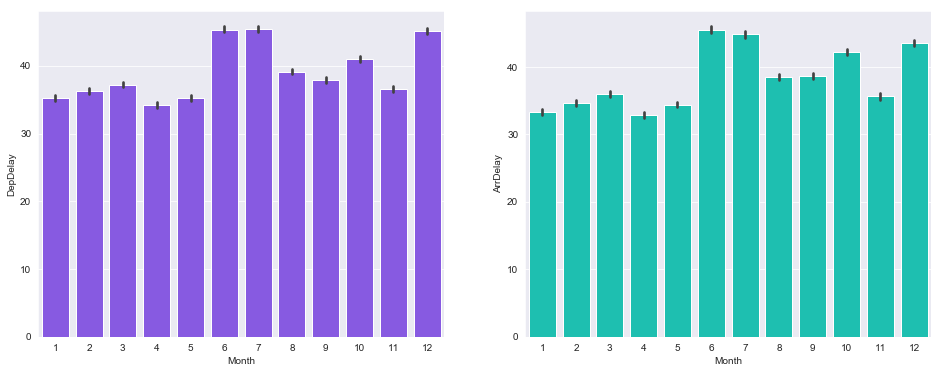

In [11]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.barplot(x='Month', y='DepDelay', data=air, color='#7F44F7')
plt.subplot(1,2,2)
sns.barplot(x='Month', y='ArrDelay', data=air, color='#03DAC6')
plt.show()

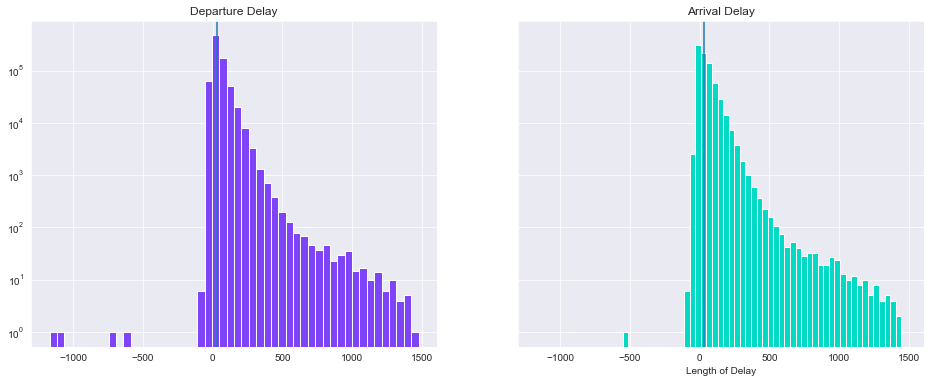

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,sharex=True, figsize=(16,6))
ax1.hist(air.DepDelay, bins=50, color='#7F44F7')
# to show the limit of where a delay is defined or not
ax1.axvline(x=30)
ax1.set_title('Departure Delay')
ax2.hist(air.ArrDelay, bins=50, color='#03DAC6')
ax2.axvline(x=30)
ax2.set_title('Arrival Delay')
plt.xlabel('Length of Delay')

plt.ylabel('')
plt.yscale('log')
plt.show()

#### Key Points
- This data is transformed/scaled so we can get a more accurate view of it's distribution. The non transformed data shows a much larger imbalance between flights with no delays.
- What we do see here though is that most flights aren't delayed, and that the most common delays after that are just barely delayed.
- The data (almost) exponentially decreases as delays get longer
- This seems obvious but departure delays and arrival delays seem to be very correlated
- There are whole lot of negatively delayed flights. Which when over three hours early, it doesn't make all that much sense.

In [12]:
# More than 3 hours early doesn't seem to make much sense
air = air.drop(air[air.DepDelay < (-180)].index)
air = air.drop(air[air.ArrDelay < (-180)].index)

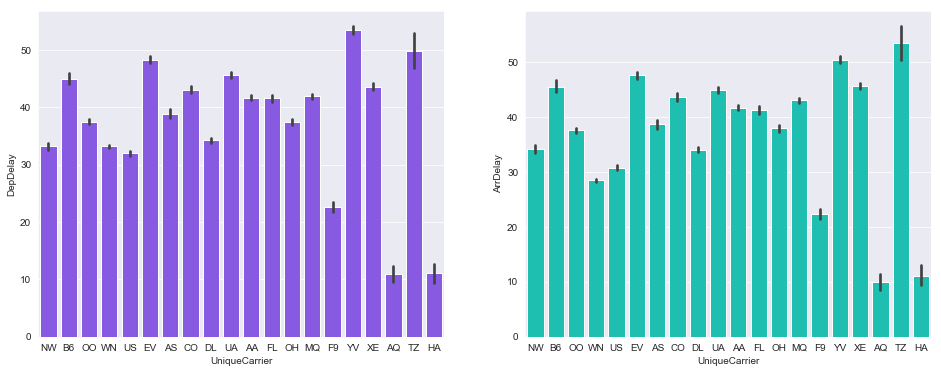

In [13]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.barplot(x='UniqueCarrier', y='DepDelay', data=air, color='#7F44F7')
plt.subplot(1,2,2)
sns.barplot(x='UniqueCarrier', y='ArrDelay', data=air, color='#03DAC6')
plt.show()

#### Key Points
- The different airlines seem pretty evenly distributed as far as how delayed they are.
- The obvious stand outs are Hawaiian Airlines(HA), Frontier(F9), and Express Jet (EV). Express Jet because of it's coniderably high rate of delays. Then Frontier and even more so Hawaiian for it's abilitity to keep delays to a minimum.
- Tsaradia(TZ) seems to have the most outliers compared to the other airlines, on top of what is a pretty high delay rate.

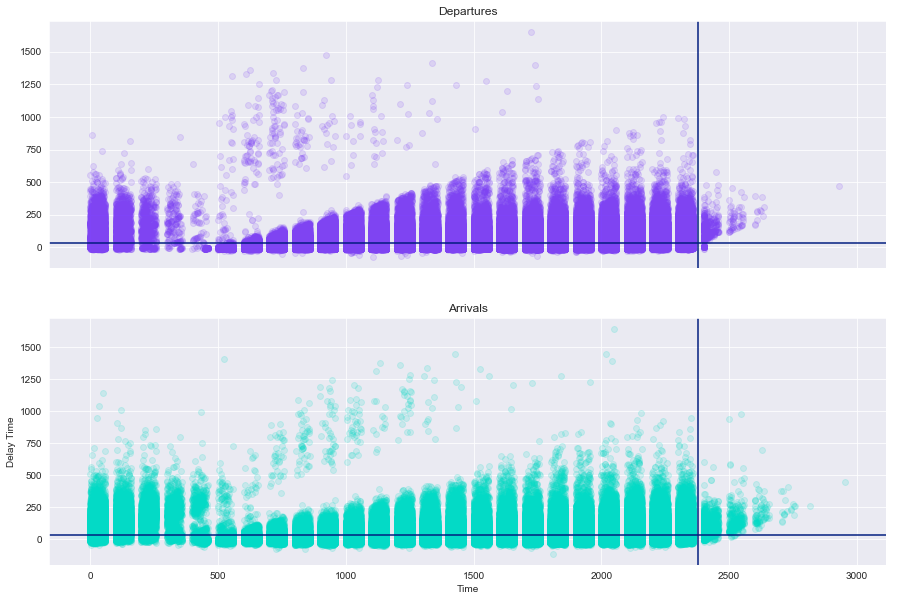

In [14]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,10))
ax1.scatter(x="DepTime", y="DepDelay", data=air, alpha=.15, color='#7F44F7')
# because delays over 30 min count as a delay
ax1.axhline(y=30)
# To show where the 24 hours starts/begins
ax1.axvline(x=2380)
ax1.set_title('Departures')
ax2.scatter(x="ArrTime", y="ArrDelay", data=air, alpha=.15, color='#03DAC6')
# because delays over 30 min count as a delay
ax2.axhline(y=30)
# To show where the 24 hours starts/begins
ax2.axvline(x=2380)
ax2.set_title('Arrivals')

plt.xlabel('Time')
plt.ylabel('Delay Time')
plt.show()

#### Key Points
- I have a feeling this data is a bit misleading, my thought is that there are probably a lot less delayed flights then there are on-time flights, so this makes it seem as if there are an even amount because of the shape of all of the data points.
- Despite that, there is a pattern here that show that as the day gets longer, the delays tend to get worse.
- The mornings have considerably less delays.
- It deos seem though that every so often an early flight can end up remarkably delayed. But put in the context of there more than likely being much more on time flights vs delayed flights, the possibility of such an extreme delay is probably very low.

In [15]:
# The braun of our data is below a 750 min delay, really so doing 800 is generous
air = air.drop(air[air.DepDelay > 800].index)
air = air.drop(air[air.ArrDelay > 800].index)

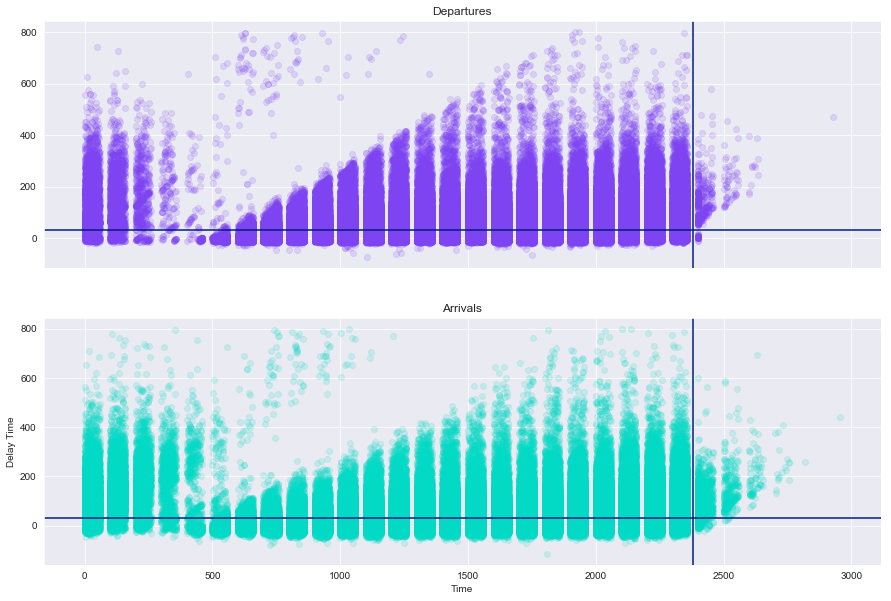

In [16]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,10))
ax1.scatter(x="DepTime", y="DepDelay", data=air, alpha=.15, color='#7F44F7')
# because delays over 30 min count as a delay
ax1.axhline(y=30)
# To show where the 24 hours starts/begins
ax1.axvline(x=2380)
ax1.set_title('Departures')
ax2.scatter(x="ArrTime", y="ArrDelay", data=air, alpha=.15, color='#03DAC6')
# because delays over 30 min count as a delay
ax2.axhline(y=30)
# To show where the 24 hours starts/begins
ax2.axvline(x=2380)
ax2.set_title('Arrivals')

plt.xlabel('Time')
plt.ylabel('Delay Time')
plt.show()

In [17]:
air.shape

(799822, 28)

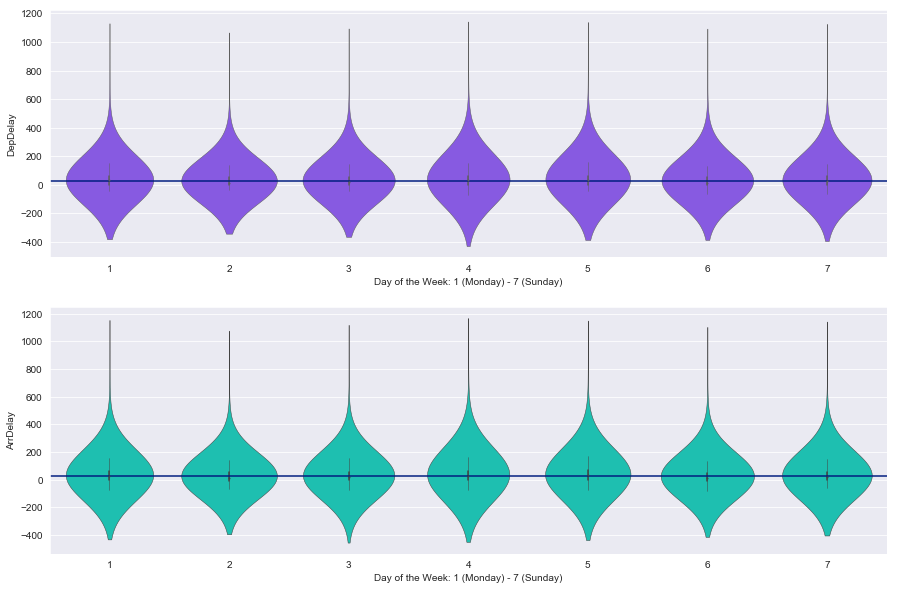

In [18]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.violinplot(x='DayOfWeek', y='DepDelay', data=air, color='#7F44F7', linewidth=.5, bw=3)
plt.xlabel('Day of the Week: 1 (Monday) - 7 (Sunday)')
plt.axhline(y=30)
plt.subplot(2,1,2)
sns.violinplot(x='DayOfWeek', y='ArrDelay', data=air, color='#03DAC6', linewidth=.5, bw=3)
plt.xlabel('Day of the Week: 1 (Monday) - 7 (Sunday)')
plt.axhline(y=30)
plt.show()

#### Key Points
- This graph proves an earlier point: the majority of flights are actually on time, with Wednesdays, Saturdays and Sundays having the highest volume of flights.
- Saturdays and Mondays seem to have the widest distributions of just barely delayed flights.
- Interestingly, the very worst delay happened on a Wednesday. This graph data is scaled to show the violen plot a little more accurately but even then, it is hard to tell just how often those outliers happen. My guess, based upon by how massive this dataset is that it happens very very rarely.
- It does seem like people fly more towards the end of the week though, from Wednesday through Friday.

In [19]:
delay_comp = pd.DataFrame()
delay_comp['departure delays'] = air.DepDelay.loc[air.DepDelay>30].describe()
delay_comp['arrival delays'] = air.ArrDelay.loc[air.ArrDelay>30].describe()
delay_comp

,departure delays,arrival delays
count,399829.000000,361377.000000
mean,77.543622,84.570368
std,55.703000,58.886129
min,31.000000,31.000000
25%,42.000000,46.000000
50%,59.000000,66.000000
75%,93.000000,103.000000
max,799.000000,800.000000


#### When Looking at the Descriptions:
- The average delay is a about 1 hour and 15 minutes, this is with a fairly large amount of variance though.
- The max delay is ridiculously long and very obviously an outlier.

In [20]:
# create binary variables of 
air['DepDelay_bin'] = np.where(air['DepDelay']>30,1,0)
air['ArrDelay_bin'] = np.where(air['ArrDelay']>30,1,0)

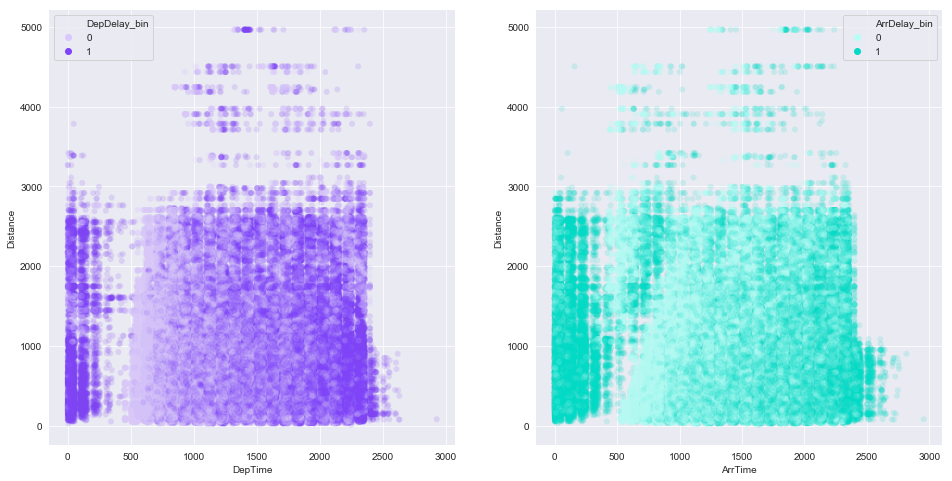

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
color1={0:'#d9c8fd', 1:'#7F44F7'}
color2={0:'#b7fef7', 1:'#03DAC6'}
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="DepTime", y="Distance", hue='DepDelay_bin',
                palette=color1, linewidth=0,
                data=air, ax=ax1, alpha=.15)
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="ArrTime", y="Distance", hue='ArrDelay_bin',
                palette=color2, linewidth=0,
                data=air, ax=ax2, alpha=.15)

**Feature idea:** Average delay by flight number

In [22]:
#delays = air[['FlightNum', 'DepDelay']].loc[air['DepDelay']>30]
#delays.FlightNum.nunique()
avgdelays = pd.DataFrame(air.groupby('FlightNum')['DepDelay'].mean().sort_values(ascending=False))
avgdelays.columns = ['AvgDepDelay']
#avgdelays['FlightNum'] = avgdelays.index

# Do the same with Arrival Delays
avgarrdelays = pd.DataFrame(air.groupby('FlightNum')['ArrDelay'].mean().sort_values(ascending=False))
avgarrdelays.columns = ['AvgArrDelay']

air = air.merge(avgdelays, on='FlightNum', how='inner')
air = air.merge(avgarrdelays, on='FlightNum', how='inner')
air.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DepDelay_bin,ArrDelay_bin,AvgDepDelay,AvgArrDelay
0,2006,3,8,3,805.0,810,914.0,916,NW,580,...,0,0,0,0,0,0,0,0,37.043814,34.095361
1,2006,1,25,3,1923.0,1917,2255.0,2258,AA,580,...,0,0,0,0,0,0,0,0,37.043814,34.095361
2,2006,5,20,6,914.0,915,1131.0,1135,FL,580,...,0,0,0,0,0,0,0,0,37.043814,34.095361
3,2006,2,13,1,1141.0,1050,1434.0,1340,UA,580,...,0,13,0,3,0,38,1,1,37.043814,34.095361
4,2006,1,8,7,1917.0,1917,2301.0,2258,AA,580,...,0,0,0,0,0,0,0,0,37.043814,34.095361


In [23]:
air = air.rename(columns={'AvgDepDelay':'flightAvgDepDelay', 'AvgArrDelay':'flightAvgArrDelay'})

---

**Two questions**
- Can you have negative delays that massive?
- There are more than 24 time blocks, how does that work?

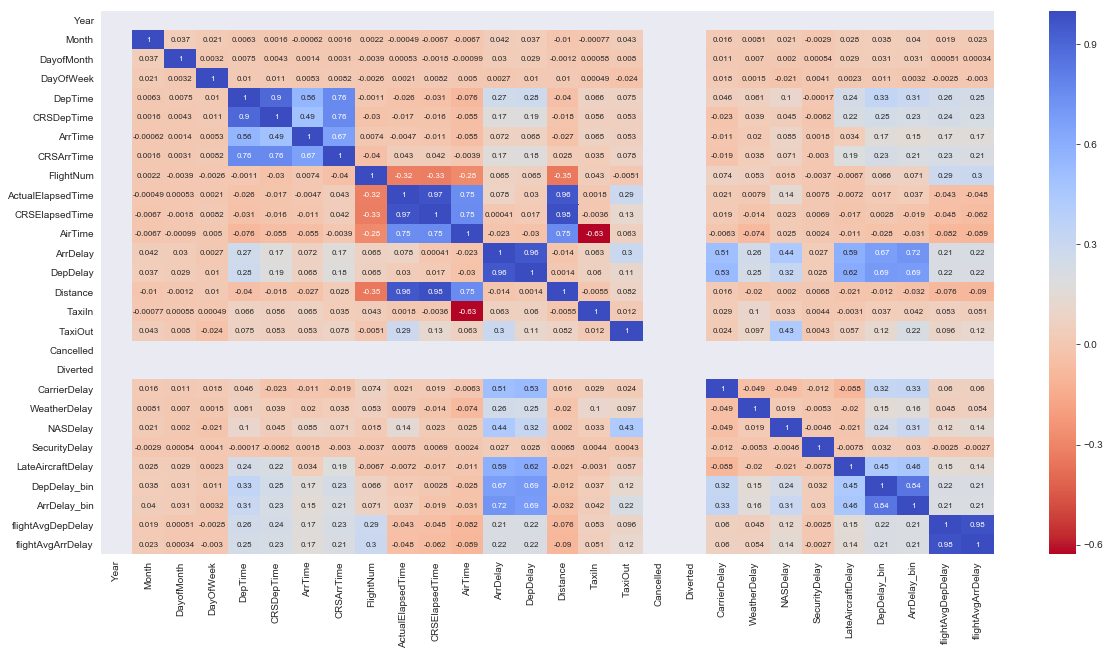

In [24]:
plt.figure(figsize=(20,10))
sample_corr = air.corr()
sns.heatmap(sample_corr, cmap='coolwarm_r', annot=True, annot_kws={'size':8})
ax2.set_title('Correlation Matrix', fontsize=14)
plt.show()

In [25]:
air.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
       'SecurityDelay', 'LateAircraftDelay', 'DepDelay_bin', 'ArrDelay_bin',
       'flightAvgDepDelay', 'flightAvgArrDelay'],
      dtype='object')

## Modeling

In [26]:
air.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum               object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance               int64
TaxiIn                 int64
TaxiOut                int64
Cancelled              int64
Diverted               int64
CarrierDelay           int64
WeatherDelay           int64
NASDelay               int64
SecurityDelay          int64
LateAircraftDelay      int64
DepDelay_bin           int64
ArrDelay_bin           int64
flightAvgDepDelay    float64
flightAvgArrDelay    float64
dtype: object

In [27]:
air[['UniqueCarrier','FlightNum', 'TailNum','Origin', 'Dest']].head(3)

,UniqueCarrier,FlightNum,TailNum,Origin,Dest
0,NW,580,N311US,OMA,MSP
1,AA,580,N487AA,DFW,FLL
2,FL,580,N969AT,ATL,EWR


In [28]:
air.FlightNum = pd.to_numeric(air.FlightNum)

In [29]:
from sklearn.feature_selection import SelectKBest, f_classif

X = air.drop(['ArrDelay', 'DepDelay','DepDelay_bin', 'ArrDelay_bin', 'CarrierDelay','WeatherDelay','NASDelay',
     'SecurityDelay','LateAircraftDelay','UniqueCarrier', 'TailNum','Origin', 'Dest'], 1)
y = air['DepDelay_bin']

selector=SelectKBest(score_func=f_classif,k=17)
selector.fit(X,y)
scores = pd.DataFrame()
scores["Attribute"] = X.columns
scores["F Score"] = selector.scores_
scores["P Value"] = selector.pvalues_
scores["Support"] = selector.get_support()

scores = scores.sort_values(by=['F Score'], ascending=False)

key_vals = scores.Attribute.head(8).values

scores

/usr/local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 0 15 16] are constant.
  UserWarning)
/usr/local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,Attribute,F Score,P Value,Support
4,DepTime,99715.364212,0.000000e+00,True
5,CRSDepTime,55426.578121,0.000000e+00,True
7,CRSArrTime,45773.289690,0.000000e+00,True
17,flightAvgDepDelay,38872.096933,0.000000e+00,True
18,flightAvgArrDelay,37850.872023,0.000000e+00,True
6,ArrTime,24584.818242,0.000000e+00,True
14,TaxiOut,12298.210484,0.000000e+00,True
8,FlightNum,3526.432784,0.000000e+00,True
1,Month,1142.337687,3.122264e-250,True
13,TaxiIn,1111.291871,1.707901e-243,True


**Select K Best:**
- We'll drop Year, Cancelled and Diverted when we make the models.
- It makes sense that arrival and departure time have such a weighted effect on the data.
- Interesting that flight number is so high as well

In [30]:
X = air[key_vals]
y = air['DepDelay_bin']

In [31]:
# to split a training and test sample
from sklearn.model_selection import train_test_split, cross_val_score
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Logistic Regression

In [32]:
# How long will it take
from datetime import datetime
start_time = datetime.now()

# get rid of the warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1e9, max_iter = 150)
lr.fit(x_train, y_train)

# Set Up Predictor
ypred_lr = lr.predict(x_test)

print('Train Percentage accuracy:')
print(lr.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(lr.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(lr, x_train, y_train, cv = 5))

from sklearn.metrics import classification_report
print('\nClassification Report:\n')
print(classification_report(y_test, ypred_lr))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

Train Percentage accuracy:
0.8188778827271423

Test Percentage accuracy:
0.8200954209926183

Cross Validation:
[0.81906913 0.81663527 0.81428476 0.82149168 0.82032474]

Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.84      0.82    100165
           1       0.84      0.80      0.82     99791

   micro avg       0.82      0.82      0.82    199956
   macro avg       0.82      0.82      0.82    199956
weighted avg       0.82      0.82      0.82    199956


Duration: 0:00:29.285554


In [42]:
start_time = datetime.now()
# get rid of the warnings
import warnings
warnings.filterwarnings("ignore")

# Grid Search CV for decision tree
from sklearn.model_selection import GridSearchCV

#GridSearchCV for random forest 
param_grid = {'C':[1e9,.5,1,3], 'max_iter':[25,50,100], 'penalty':['l1','l2']}

# Start the grid search again
grid_DT = GridSearchCV(lr, param_grid, cv=3, verbose=1, n_jobs=-1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:')
print(grid_DT.best_params_)

# Set Up Predictor
ypred_lr = lr.predict(x_test)

from sklearn.metrics import classification_report
print('\nClassification Report:\n')
print(classification_report(y_test, ypred_lr))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 17.9min finished


Best score for data:
{'C': 1000000000.0, 'max_iter': 50, 'penalty': 'l2'}

Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.84      0.82    100165
           1       0.84      0.80      0.82     99791

   micro avg       0.82      0.82      0.82    199956
   macro avg       0.82      0.82      0.82    199956
weighted avg       0.82      0.82      0.82    199956


Duration: 0:17:58.463669


#### Logistic Regression Insights
- For a first fit, these scores are pretty good.
- The model doesn't seem to overfit at all, with low variance amongst the cross validation scores, and the test/train set perform similarly.
- The precision and recall scores are also even. It is good that we're not over predicting one of the classifiers over the other. The recall and precision scores could be higher but like the r2 scores, the 80% accuracy should perform pretty well.

### Naive Bayes

In [36]:
start_time = datetime.now()

from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(x_train, y_train)
# Set Up Predictor
ypred_bnb = bnb.predict(x_test)

print('\nTrain Percentage accuracy:')
print(bnb.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(bnb.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(bnb, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_bnb))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.5002767413868411

Test Percentage accuracy:
0.5010177697089728

Cross Validation:
[0.50017505 0.50028341 0.50026674 0.50037094 0.50028758]

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.00      0.00     99888
           1       0.50      1.00      0.67    100059

   micro avg       0.50      0.50      0.50    199947
   macro avg       0.72      0.50      0.33    199947
weighted avg       0.72      0.50      0.34    199947


Duration: 0:00:01.585350


#### Naive Bayes Insights
- The scores for bayes are a little too low to return any sort of meaningful impact here.
- The recall score on non-delayed flights being 0 is no good and would make just about any result we get from this model be unreliable.
- On the plus side, the model doesn't seem to overfit at all. The test and training scores are pretty even, along with very low variance in the cross validation scores.

### K Nearest Neighbors

In [37]:
start_time = datetime.now()

from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=30)
knn.fit(x_train, y_train)
# Set Up Predictor
ypred_knn = knn.predict(x_test)

print('\nTrain Percentage accuracy:')
print(knn.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(knn.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(knn, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_knn))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.9383100103694664

Test Percentage accuracy:
0.9337574457231166

Cross Validation:
[0.93114831 0.93137337 0.9306315  0.93057257 0.92968066]

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.95      0.93     99888
           1       0.95      0.92      0.93    100059

   micro avg       0.93      0.93      0.93    199947
   macro avg       0.93      0.93      0.93    199947
weighted avg       0.93      0.93      0.93    199947


Duration: 0:01:27.659462


#### KNN Insights
- KNN performs much better than both the logistic regression and bayes.
- The cross validation scores are all very high and have a very low variance between them.
- There does not seem to be any overfitting, as both the test score is similar to the train score but also the cross validation has low variance.
- We can expect a few false positives, and incorrect returns with the precision and recall scores not being 100% but having for 90% accuracy with both of those puts this model in a very good position to perform well.

### Decision Tree

In [38]:
start_time = datetime.now()
from sklearn import tree

dec_tr = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=20,
    random_state = 1337
)

dec_tr.fit(x_train, y_train)
# Set Up Predictor
ypred_dec_tr = dec_tr.predict(x_test)

print('\nTrain Percentage accuracy:')
print(dec_tr.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(dec_tr.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(dec_tr, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_dec_tr))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.8916907565042561

Test Percentage accuracy:
0.8457941354458932

Cross Validation:
[0.80410609 0.83632302 0.81647606 0.84970033 0.83581318]

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.86      0.85     99888
           1       0.86      0.83      0.84    100059

   micro avg       0.85      0.85      0.85    199947
   macro avg       0.85      0.85      0.85    199947
weighted avg       0.85      0.85      0.85    199947


Duration: 0:00:05.237410


#### Decision Tree Insights
- The train score here is pretty good, unfortunately the difference between the train score and the test score is a bit too large and might mean there is a bit of overfitting.
- This is similarly reflected in the variance of the corss validation scores.
- The slight overfitting is unfortunate because the precision and recall scores are both pretty good and the model is predicting both the dependent variable and the independent variable pretty evenly well.

### Gradient Boosted Decision Tree

In [44]:
start_time = datetime.now()
from sklearn import ensemble

clf = ensemble.GradientBoostingClassifier(loss='exponential', max_depth=8 , n_estimators=50 )
clf.fit(x_train, y_train)

ypred_clf = clf.predict(x_test)

print('\nTrain Percentage accuracy:')
print(clf.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(clf.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(clf, x_train, y_train, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test, ypred_clf))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.9957807243617741

Test Percentage accuracy:
0.9954940086819101

Cross Validation:
[0.99483221 0.99453215 0.99479054 0.99504051 0.99485713]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    100165
           1       0.99      1.00      1.00     99791

   micro avg       1.00      1.00      1.00    199956
   macro avg       1.00      1.00      1.00    199956
weighted avg       1.00      1.00      1.00    199956


Duration: 0:15:28.736286


In [45]:
print('\nLarger Cross Validation:')
cv = cross_val_score(clf, x_train, y_train, cv = 10)
print(cv)

print('\nLarger Cross Validation Mean:',cv.mean())

print('\nLarger Cross Validation STD:',cv.std())


Larger Cross Validation:
[0.99498225 0.99534899 0.99543234 0.99549902 0.99518229 0.99501559
 0.99504893 0.99503226 0.99406518 0.99566558]

Larger Cross Validation Mean: 0.9951272433386101

Larger Cross Validation STD: 0.00041832277438023035


#### Gradient Boosted Decision Tree Insights
- Whoa, this model is able to predict at a very high accurracy with almost no sign of overfitting.
- A 99% accurracy would normally make me think the model might be overfitting but the cross validation score all come out very close to each other.
- The main downside of this model is the general performance. 99% accuracy is almost too good to pass up but it taking 14 minutes to run makes you wonder if it is all worth it.
- Generally though, this model outperforms the others by far and would be the pick of the bunch for moving forward with into production.

In [41]:
start_time = datetime.now()
rfc = ensemble.RandomForestClassifier(n_estimators=50, max_depth=8)
rfc.fit(x_train, y_train)

ypred_rfc = rfc.predict(x_test)

print('\nTrain Percentage accuracy:')
print(rfc.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(rfc.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(rfc, x_train, y_train, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test, ypred_rfc))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.8570864133315995

Test Percentage accuracy:
0.8552966536132075

Cross Validation:
[0.863747   0.87034876 0.85956255 0.86065335 0.8767161 ]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85     99888
           1       0.85      0.86      0.86    100059

   micro avg       0.86      0.86      0.86    199947
   macro avg       0.86      0.86      0.86    199947
weighted avg       0.86      0.86      0.86    199947


Duration: 0:03:18.617362


#### Random Forest Insights
- This model works probably 3rd best among the options, it performs pretty well from an accuracy standpoint and has very little overfitting.
- It has very even precision and recall, so the only worry there is the degree of accuracy which it is predicting.
- Finally, the technical cost of this model isn't too huge. Taking 3 minutes to run isn't ideal but also is not all that inconvenient compared to the technical cost of the other models we are running.

### Support Vector Machines
Because the technical cost was far too large, we won't be running SVC on this model.

In [ ]:
#from sklearn.svm import SVC

#svc = SVC(kernel = 'linear')
#svc.fit(x_train, y_train)
#ypred_svc = svc.predict(x_test)

#print('\nTrain Percentage accuracy:')
#print(svc.score(x_train, y_train))

#print('\nTest Percentage accuracy:')
#print(svc.score(x_test, y_test))

#print('\nCross Validation:')
#print(cross_val_score(svc, x_train, y_train, cv = 5))

#print('\nLogistic Regression:\n')
#print(classification_report(y_test, ypred_svc))

## Conclusion

After running all of the models, the gradient boosted decision tree comes out as the model we would move forward with in a production environment. This of course is with the caveat that performance is pretty slow with the model and would almost certainly need to be run on holdout groups of the dataset. If performance is an issue in this scenario, then K Nearest Neighbors(KNN) would be the backup. Going with KNN would cause us to lose some accuracy with how the model predicts, but would greatly speed up the technical cost.

Ultimately, when looking at the features and how the models played out, it makes sense why these two seemed to bubble to the top. The feature set seems to rely heavily on different variations of arrival vs departure time, then also the historical average delay for a flight. If we wanted to speed up the models (while possibly losing some performance) we could combine some of those more similar features. Like the different arrival/departure times and only using one historical average delay, probably the departure delay.